In [1]:
# !pip install kagglehub

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

import kagglehub
DATASET_PATH = os.environ.get("DATASET_PATH") or kagglehub.dataset_download(
    'hkayan/industrial-robotic-arm-imu-data-casper-1-and-2') + '/'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/guaxim/Projetos/ai/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import re
normalPattern = "IMU_(.*)Hz.csv"

normal = ("IMU_10Hz.csv", ("label", 0))
faulty =("IMU_magnet.csv", ("label", 1))

df = pd.read_csv(DATASET_PATH + normal[0])
df['label'] = 0

faultydf = pd.read_csv(DATASET_PATH+faulty[0])
faultydf['label'] = 1



In [7]:
df.shape, faultydf.shape

((874937, 12), (15118, 12))

In [8]:
df.isnull().values.any()
# Sem NAs

np.False_

# PREPARAÇÂO DOS DADOS
- convertendo o timestamp de ns pra s
- aplicando filtragem Savitzky–Golay para reduzir o ruído dos sensores
- apresentar a quantidade alta de zeros nos sensores causada pelos frequentes momentos de inércia do braço

In [9]:
#ns pra ms
df['time'] = (df['time'].map(lambda x: x/1e6))
faultydf['time'] = faultydf['time'].map(lambda x: x/1e6)

print(f"A frequência é {1/(df['time'].diff().mean()/1000):.2f}Hz")

A frequência é 9.98Hz


In [10]:

cols = ["accX", "accY","accZ","gyroX", "gyroY", "gyroZ", "magX", "magY", "magZ"]


In [11]:
df.loc[:, cols].describe( #remover time e label
        ).T.style.format("{:.4f}"
        ).background_gradient(cmap="Blues")

,count,mean,std,min,25%,50%,75%,max
accX,874937.0000,9.2692,1.5163,1.1564,9.3948,9.8521,9.9575,12.0668
accY,874937.0000,-0.6796,3.0819,-9.8474,-0.6728,-0.0383,0.2466,8.4755
accZ,874937.0000,0.4951,0.2348,-0.8356,0.3783,0.4956,0.5866,1.9082
gyroX,874937.0000,0.3487,28.0195,-81.7500,-4.0000,0.0000,1.1875,98.0625
gyroY,874937.0000,0.6639,8.0825,-27.8750,-0.3750,0.0000,0.1875,53.2500
gyroZ,874937.0000,0.0182,26.3745,-100.9375,-3.0625,0.0000,1.3125,114.1250
magX,874937.0000,-33.3438,5.8454,-51.6400,-35.9600,-35.1600,-32.2800,0.0000
magY,874937.0000,19.5896,19.2806,-48.7600,14.6800,30.2000,30.8800,40.9600
magZ,874937.0000,-2.4805,31.4547,-59.3846,-35.6154,6.6154,17.6923,52.7692


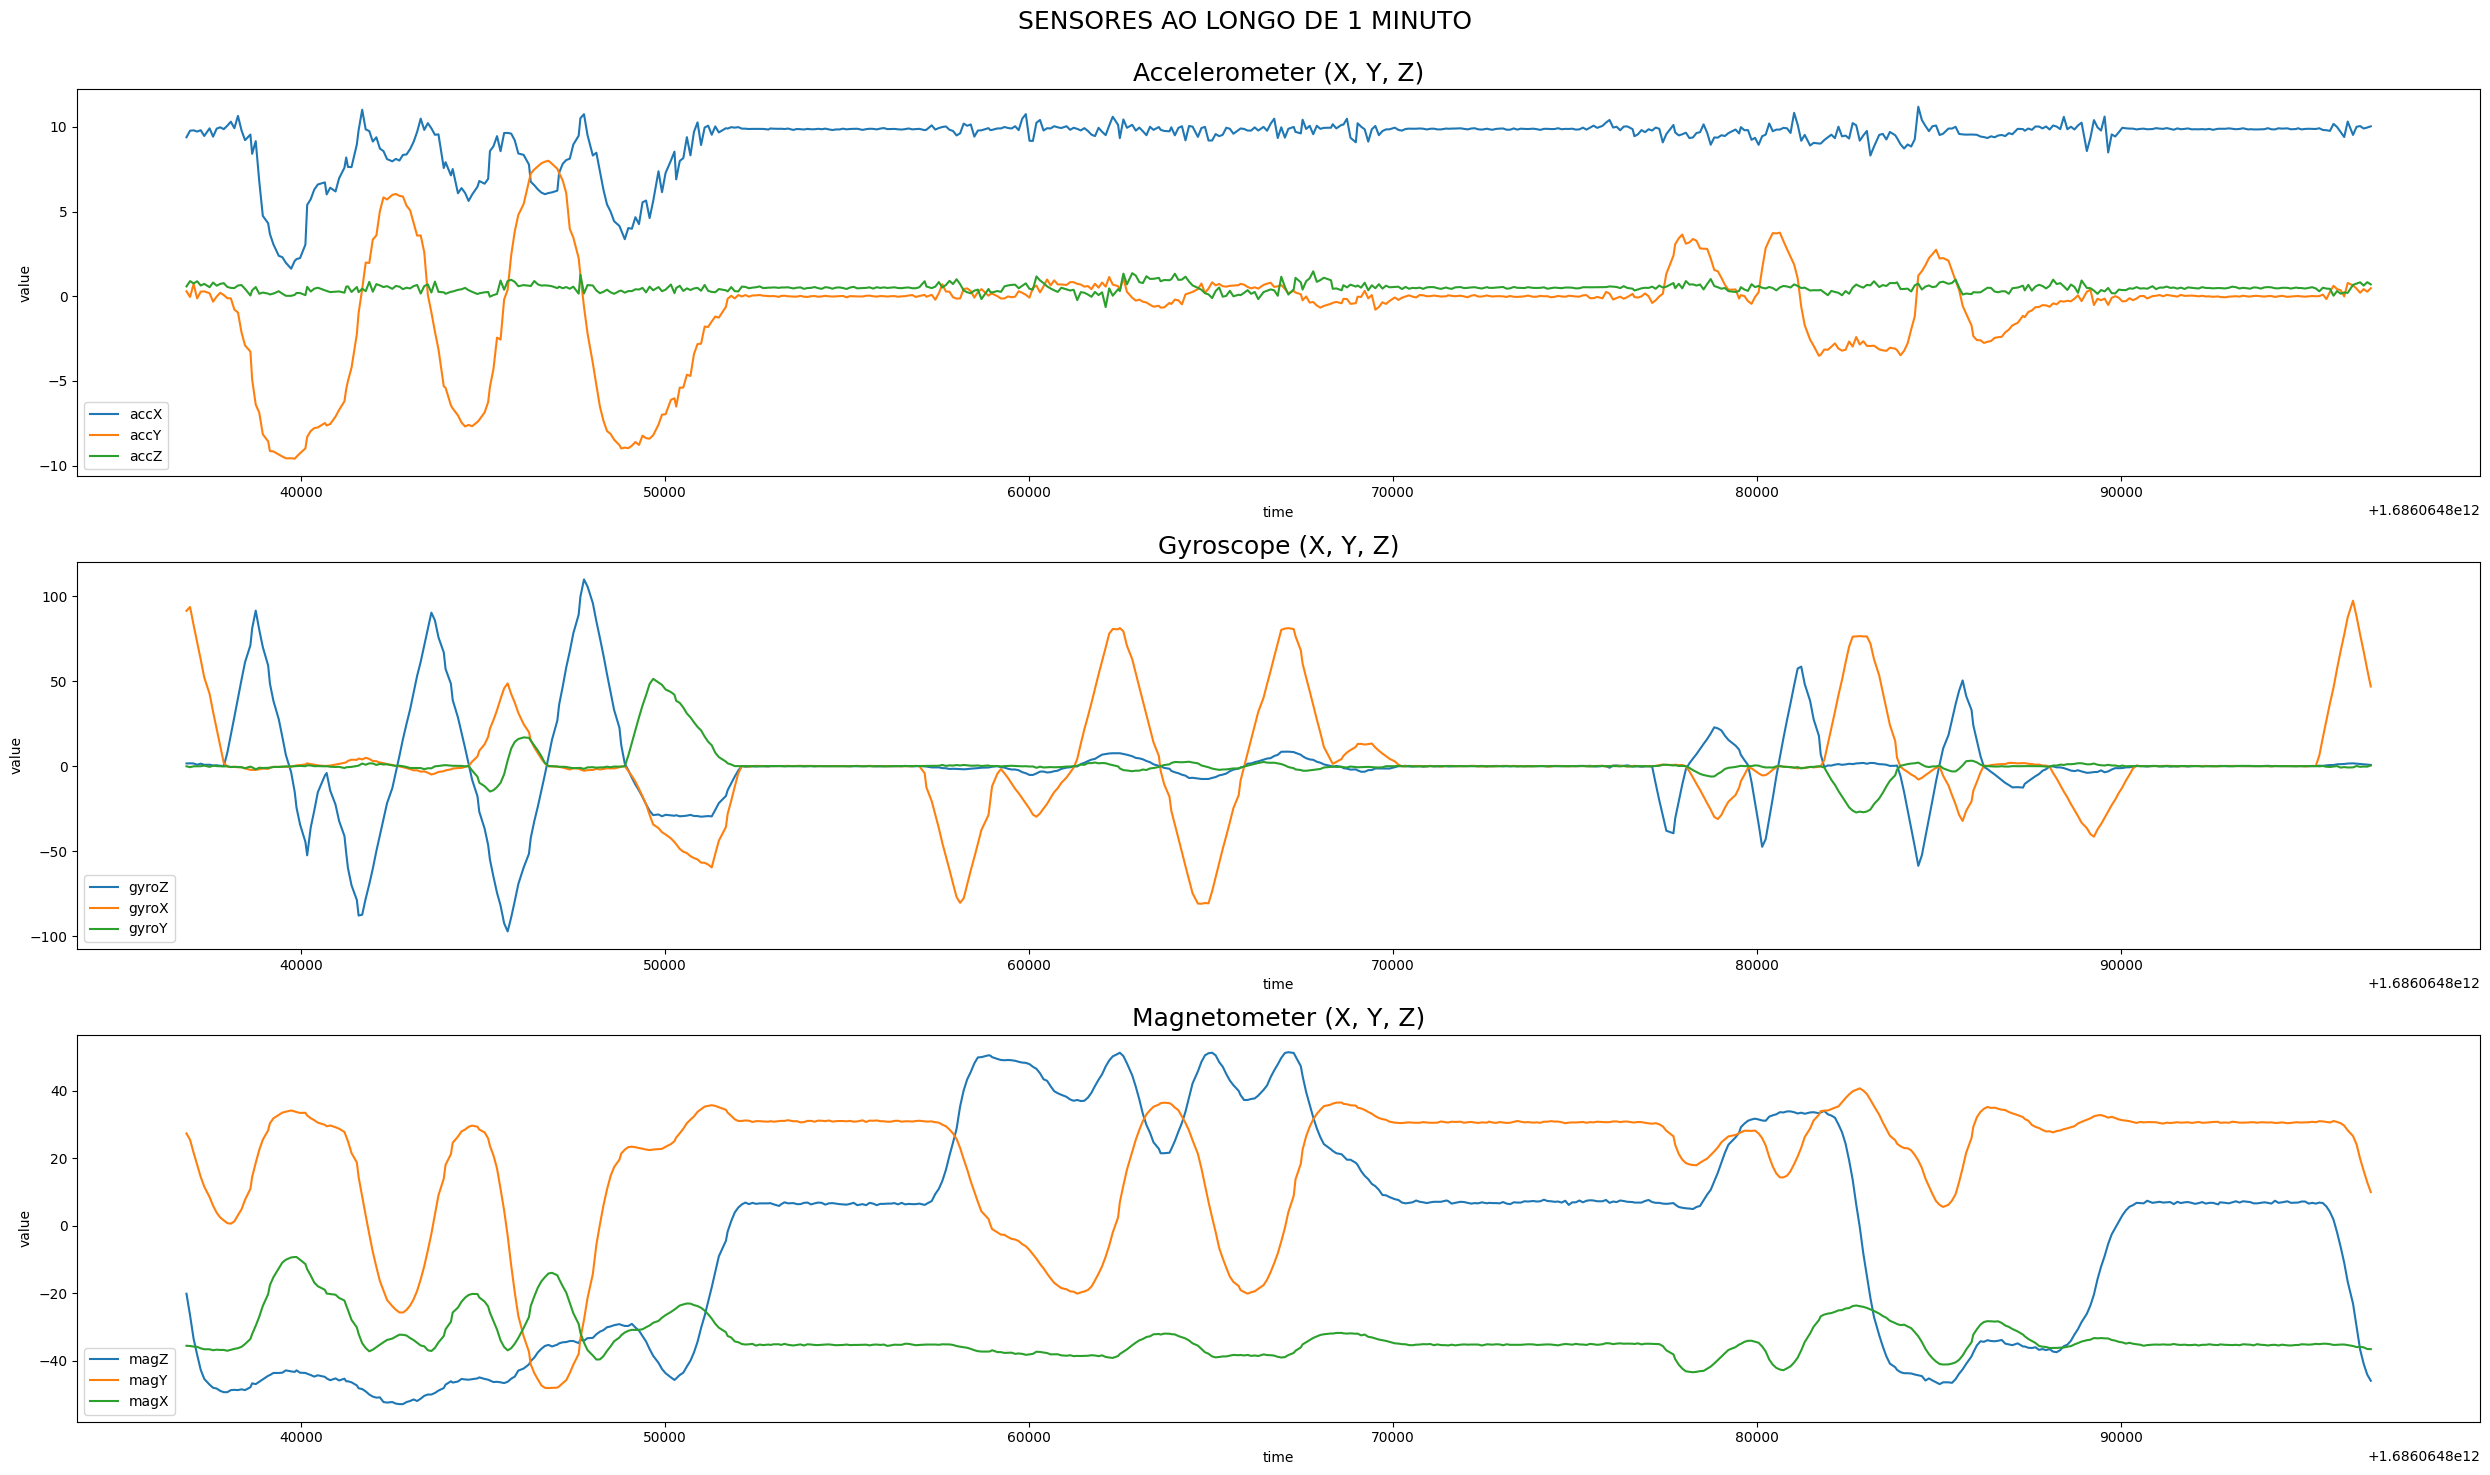

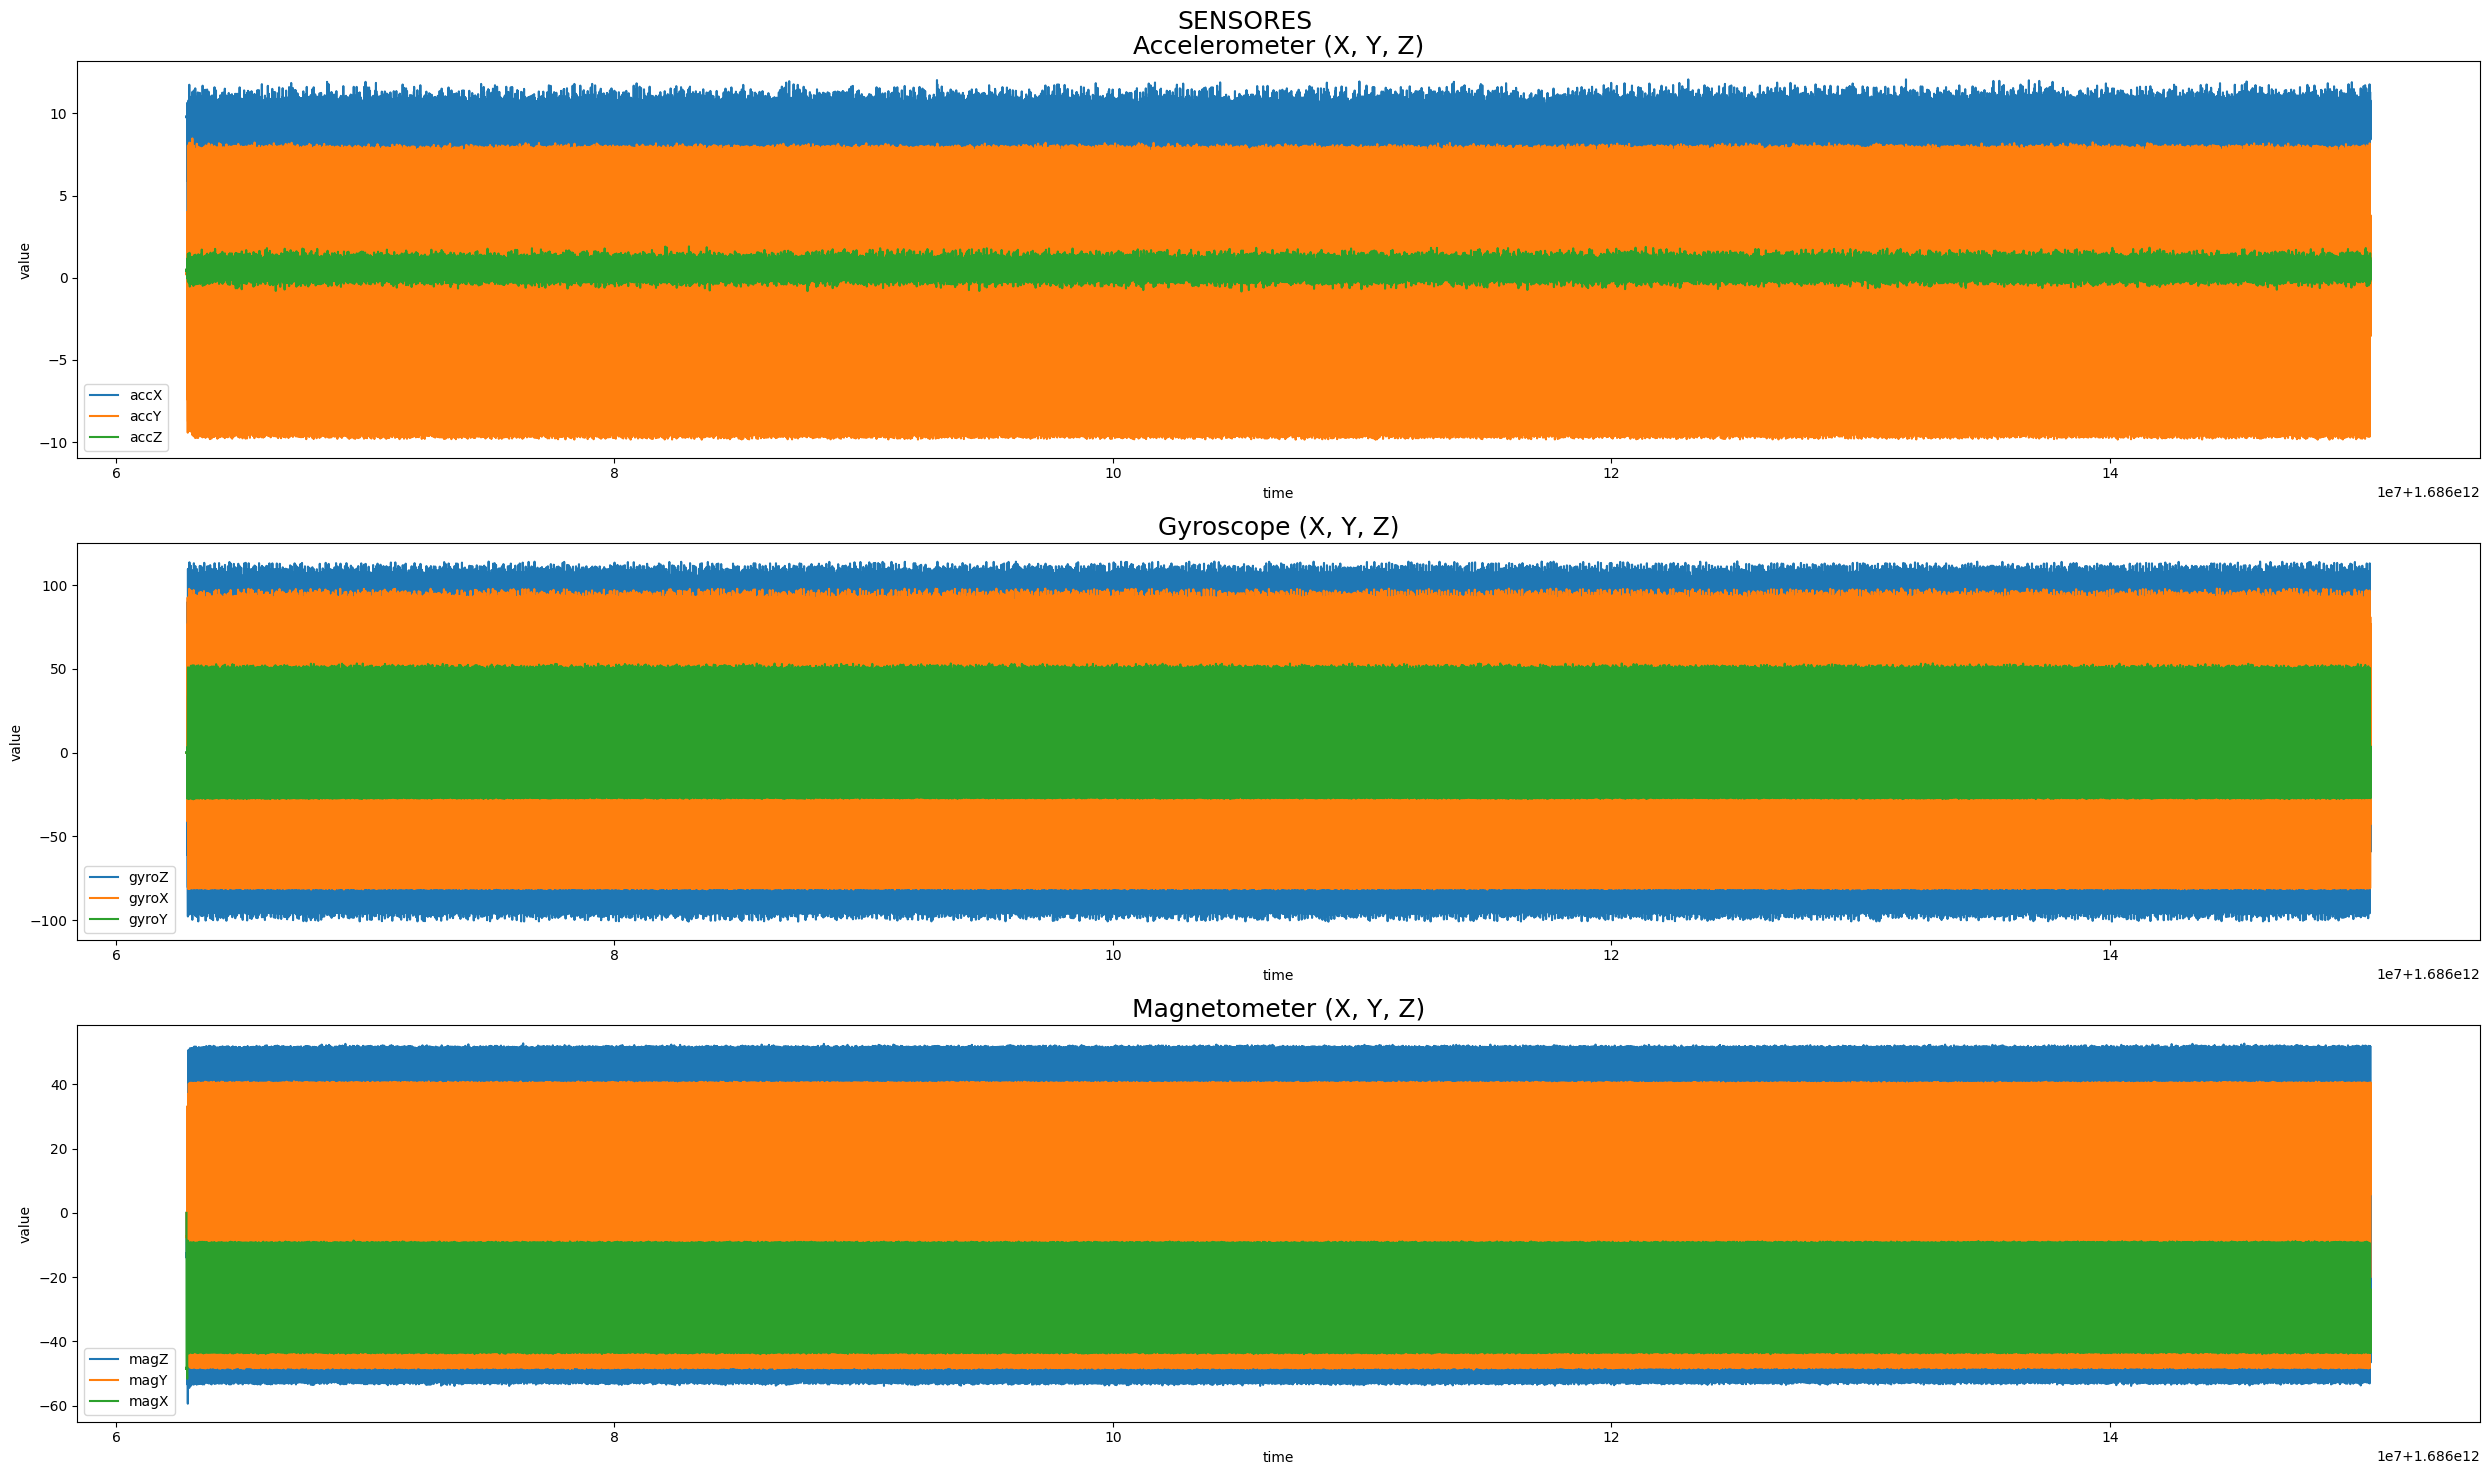

In [12]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
def plotSensors(dfPlot, step=1,suptitle="SENSORES AO LONGO DE 1 MINUTO\n",startTimeIdx=None,endTimeIdx=None):
    df = dfPlot.iloc[::step]
    fig = plt.figure(figsize=(25, 15))

    if not any((startTimeIdx, endTimeIdx)):
        startTimeIdx,endTimeIdx =  df['time'].iloc[0],df['time'].iloc[-1]
    else:
        startTimeIdx,endTimeIdx =  df['time'].iloc[startTimeIdx],df['time'].iloc[endTimeIdx]

    # Helper to plot three axes in the same subplot
    def plotSensorsSameGraph(ax, cols, title, x="time"):
        for col in cols:
            mask = (df['time'] >= startTimeIdx) & (df['time'] < endTimeIdx)
            ax.plot(df[mask][x], df[mask][col], label=col)

        ax.set_title(title, fontsize=18)
        ax.set_xlabel(x)
        ax.set_ylabel("value")
        ax.legend(loc='lower left')

    # === Subplots ===
    ax1 = fig.add_subplot(3, 1, 1)
    plotSensorsSameGraph(ax1,
                         cols=["accX", "accY","accZ"],
                         title="Accelerometer (X, Y, Z)")

    ax2 = fig.add_subplot(3, 1, 2)
    plotSensorsSameGraph(ax2,
                         cols=["gyroZ","gyroX", "gyroY", ],
                         title="Gyroscope (X, Y, Z)")

    ax3 = fig.add_subplot(3, 1, 3)
    plotSensorsSameGraph(ax3,
                         cols=["magZ", "magY", "magX"],
                         title="Magnetometer (X, Y, Z)")
    plt.suptitle(suptitle, fontsize='18')
    plt.tight_layout()
    plt.show()
plotSensors(df,startTimeIdx=20050, endTimeIdx=20050 + 60*10)
plotSensors(df,suptitle="SENSORES")

In [15]:
from scipy.signal import savgol_filter
# Savitzky-golay, um filtro bom pra series temporais (inspirado por https://www.nixtla.io/blog/polynomial_filtering)
for col in cols:
  df[col + "_smooth"] = savgol_filter(df[col], window_length=8, polyorder=2)


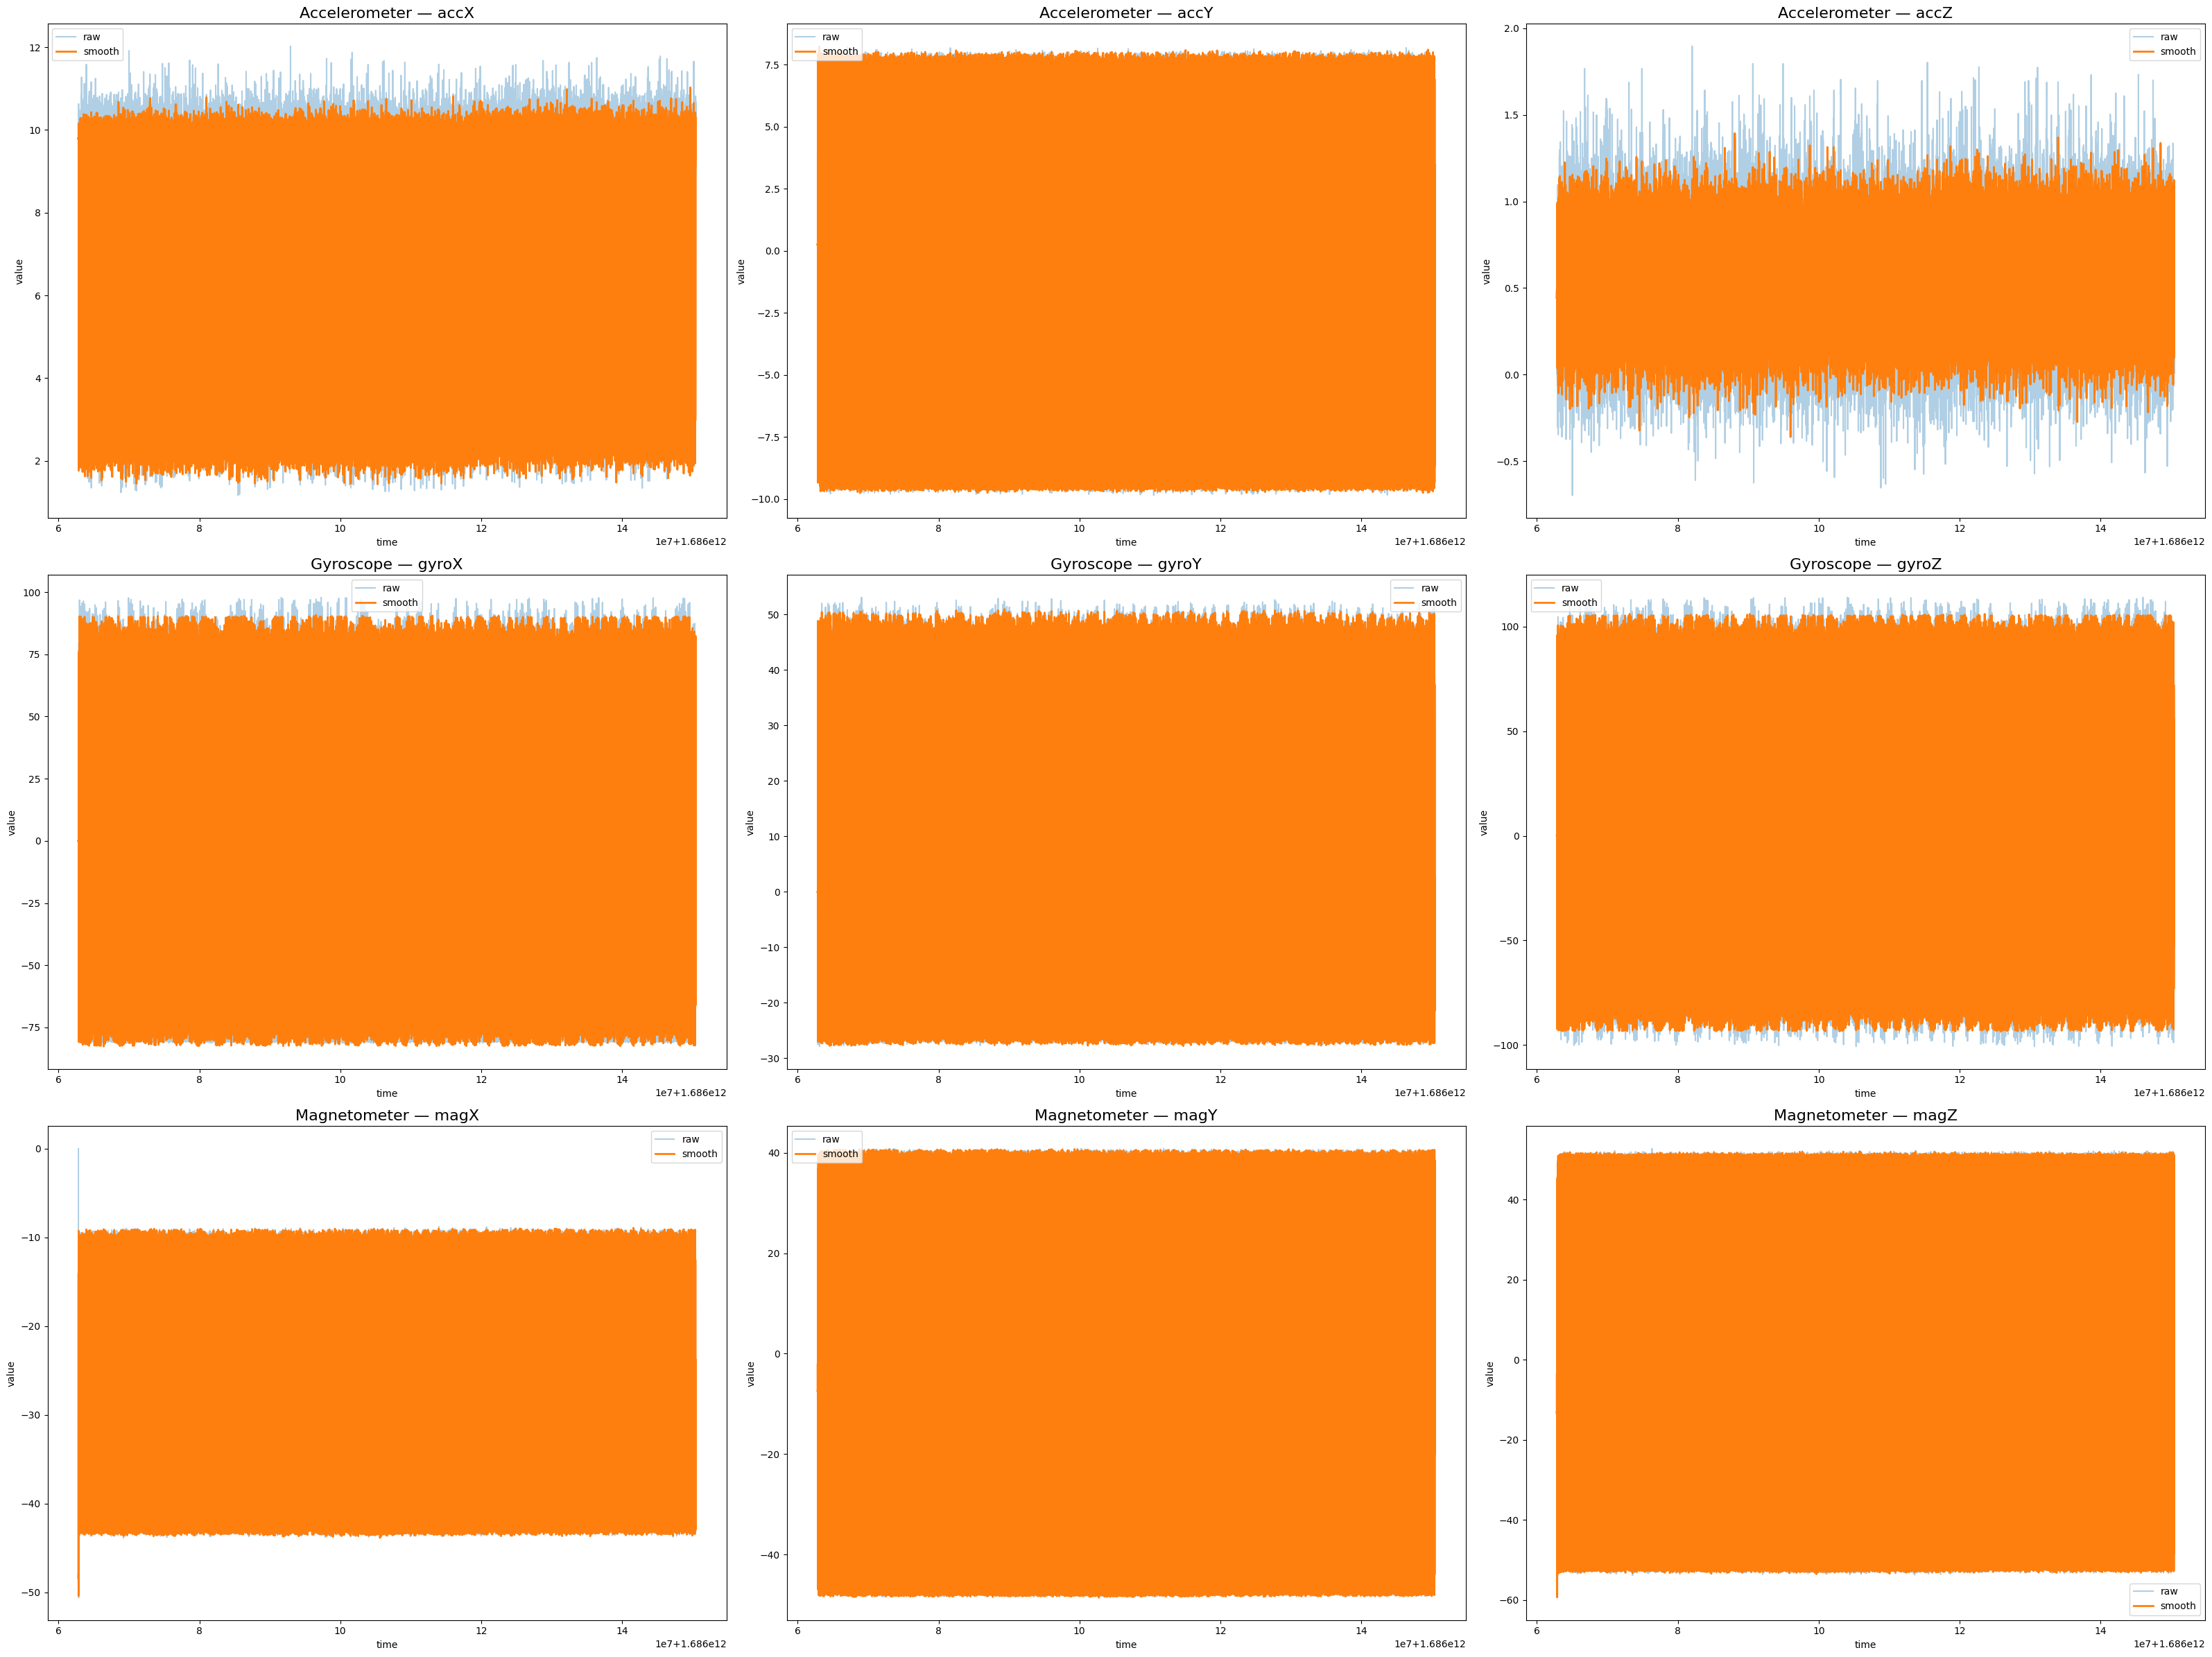

In [16]:
sensor_groups = [
    ("Accelerometer", ["accX", "accY", "accZ"]),
    ("Gyroscope", ["gyroX", "gyroY", "gyroZ"]),
    ("Magnetometer", ["magX", "magY", "magZ"])
]
def plot_raw_vs_smooth(df,step=10):
    fig, axes = plt.subplots(3, 3, figsize=(32, 24))
    df = df.iloc[::step]

    for row, (title, cols) in enumerate(sensor_groups):
        for col, axis in enumerate(cols):
            ax = axes[row][col]

            raw = df[axis]
            smooth = df[axis + "_smooth"]

            ax.plot(df["time"], raw, label="raw", alpha=0.35)
            ax.plot(df["time"], smooth, label="smooth", linewidth=2)

            ax.set_title(f"{title} — {axis}", fontsize=16)
            ax.set_xlabel("time")
            ax.set_ylabel("value")
            ax.legend()

    plt.tight_layout()
    plt.show()
plot_raw_vs_smooth(df)

## Comparação antes e depois da filtragem

1. adicionar a imagem aqui porque é muito lento pra calcular)

1. Adicionar metricas de ruído


## Normalização dos sinais com z-score

In [17]:
means = df[cols].mean()
stds = df[cols].std()

for col in cols:
    df[col + "_norm"] = (df[col] - means[col]) / stds[col]
    faultydf[col + "_norm"] = (faultydf[col] - means[col]) / stds[col]

In [19]:
def plot_raw_vs_normalized(dfPlot, step=10):
    fig, axes = plt.subplots(3, 3, figsize=(40, 16))
    df = dfPlot.iloc[::step]

    for row, (title, cols) in enumerate(sensor_groups):
        for col, axis in enumerate(cols):
            ax = axes[row][col]

            raw = df[axis]
            norm = df[axis + "_norm"]

            ax.plot(df["time"], raw, label="raw", alpha=0.35)
            ax.plot(df["time"], norm, label="normalized", linewidth=2)

            ax.set_title(f"{title} - {axis}", fontsize=16)
            ax.set_xlabel("time")
            ax.set_ylabel("value")
            ax.legend()


    plt.tight_layout()
    plt.show()

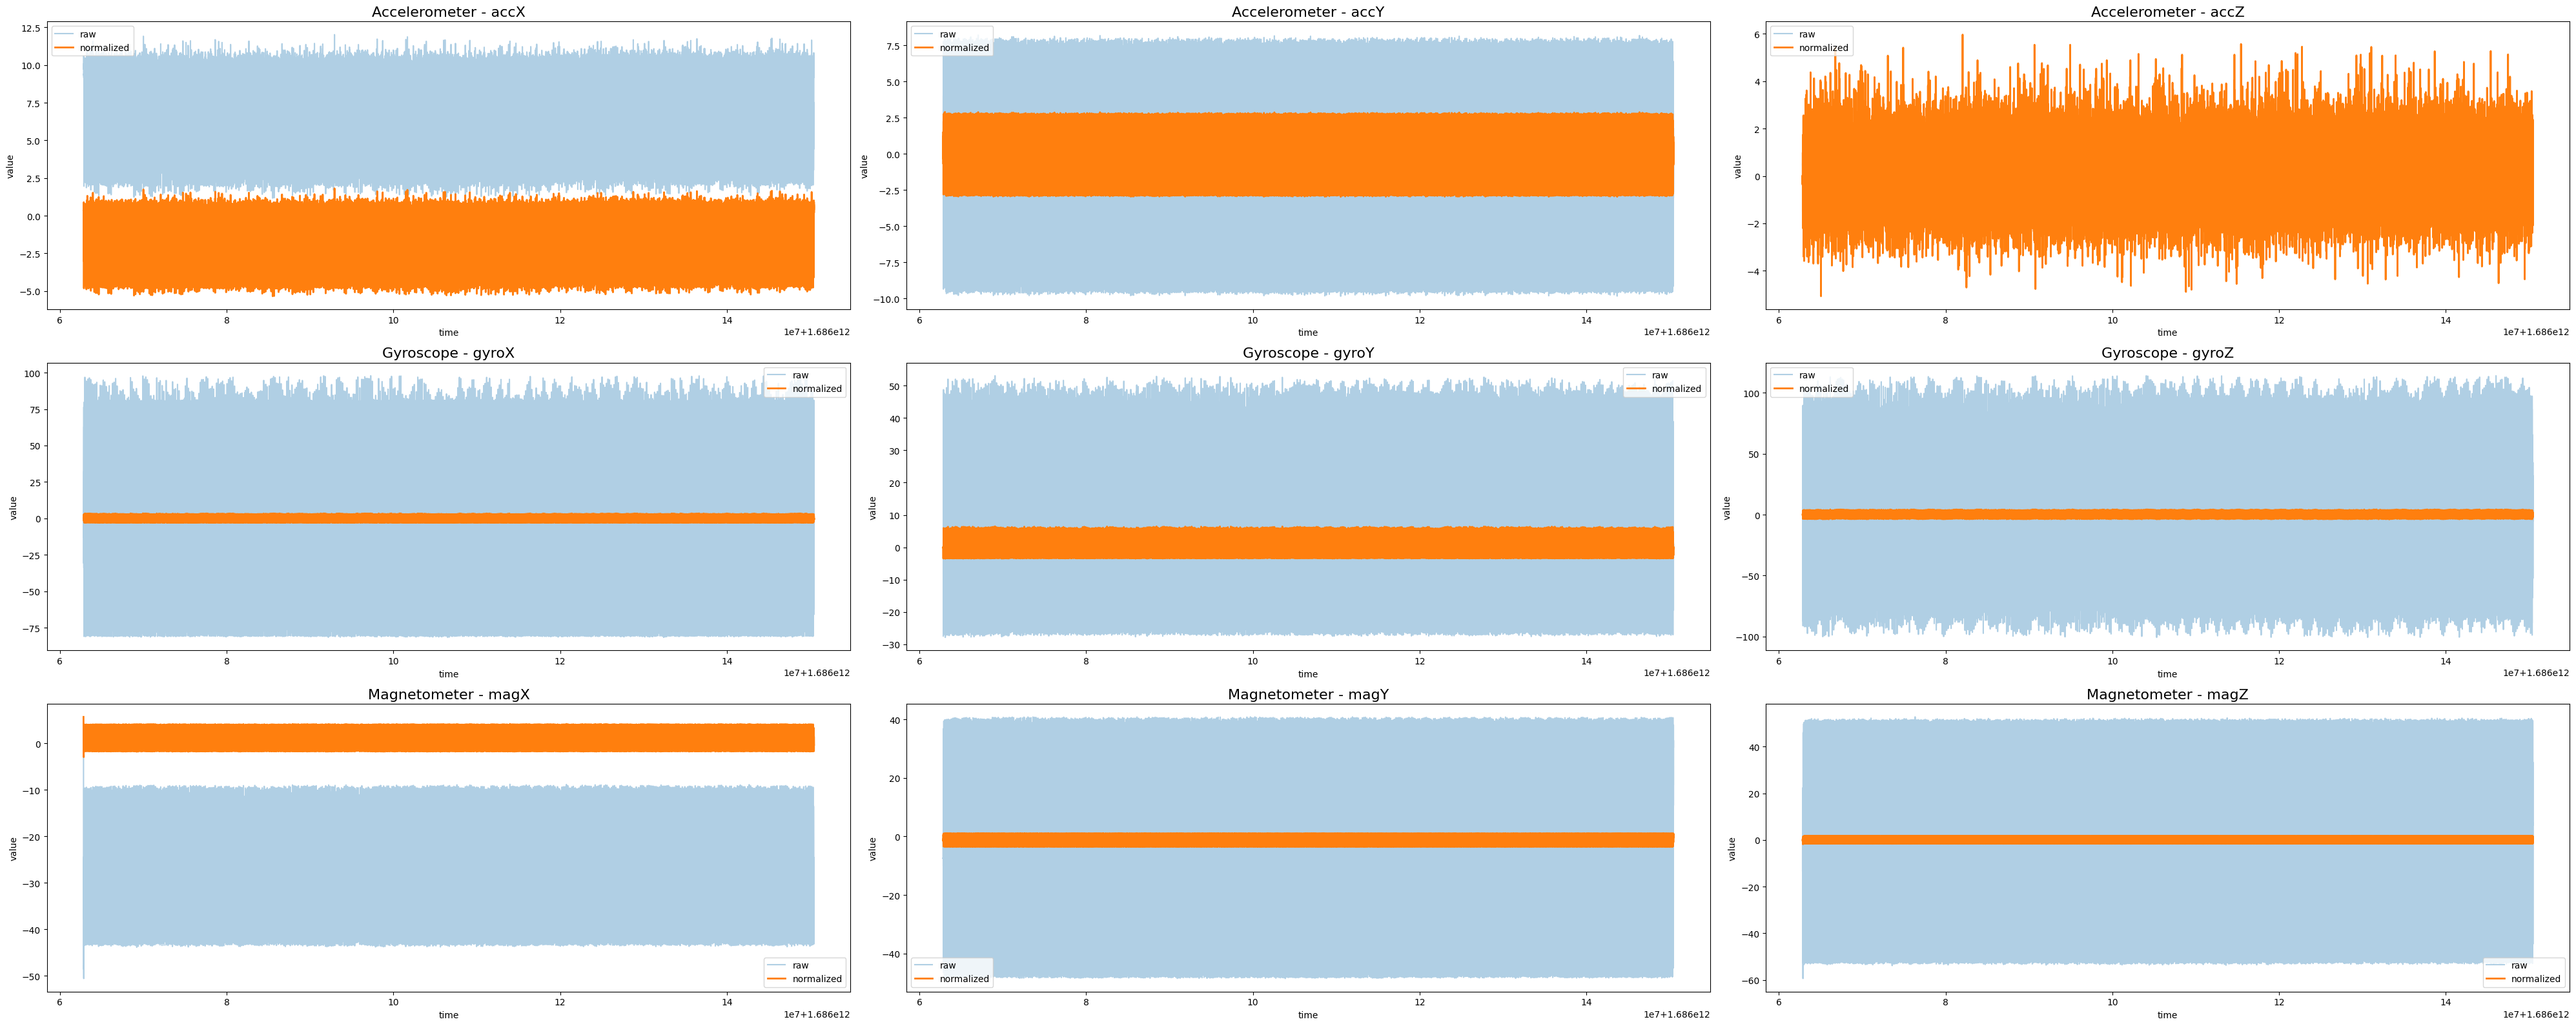

In [20]:
plot_raw_vs_normalized(df)

In [ ]:
# remover colunas smooth e normalized e substituir a coluna original pela normalizada
# de cada sensor

def remove_unused_columns(df):
    sensor_groups = ["acc", "gyro", "mag"]

    smooth_cols = [c for c in df.columns if c.endswith("_smooth")]
    df = df.drop(columns=smooth_cols)

    for s in sensor_groups:
        axes = ["X","Y","Z"]
        for ax in axes:
            raw = f"{s}{ax}"
            norm = f"{s}{ax}_norm"

            if norm in df.columns:
                df[raw] = df[norm]  

    norm_cols = [c for c in df.columns if c.endswith("_norm") or c in ['label', 'name', 'time'] and c in df.columns]
    df = df.drop(columns=norm_cols)
    return df


df = remove_unused_columns(df)
faultydf = remove_unused_columns(df)

In [24]:
#separar manualmente e sem shuffling para nunca treinar com dados futuros
def train_test_split(df: pd.DataFrame, trainPer=0.6,valPer=0.05, testPer=0.35):
    size = df.shape[0]

    traindf = df.iloc[:int(size*trainPer)]
    valdf = df.iloc[int(size*trainPer)  : int(size*(valPer + trainPer))  ] 
    testdf = df.iloc[int(size*(valPer+ trainPer)): ] 
    return traindf,valdf,testdf

X = df
X_train, X_val,X_test = train_test_split(df)

In [ ]:
def getFixedWindows(df, length, overlap, drop_incomplete=True):
    arr = df.values
    step = length - overlap
    n = arr.shape[0]

    starts = range(0, n - length + 1, step)
    windows = np.stack([arr[s:s+length] for s in starts], axis=0)
    return windows

WINDOW_SIZE, WINDOW_OVERLAP = 60, 10

X_train_w = getFixedWindows(X_train, WINDOW_SIZE, WINDOW_OVERLAP)
X_test_w  = getFixedWindows(X_test,  WINDOW_SIZE, WINDOW_OVERLAP)
Y_test_w  = getFixedWindows(faultydf, WINDOW_SIZE, WINDOW_OVERLAP)

X_train_w.shape, Y_test_w.shape
# matrizes 3d, precisam ser flattened

((10499, 60, 9), (302, 60, 9))

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np


X_train_flat = X_train_w.reshape(X_train_w.shape[0], -1)
X_test_flat  = X_test_w.reshape(X_test_w.shape[0], -1)
Y_test_flat  = Y_test_w.reshape(Y_test_w.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)


iso = IsolationForest(
    n_estimators=300,
    contamination="auto",
    bootstrap=False,
    random_state=42
)

iso.fit(X_train_scaled)


,n_estimators,300
,max_samples,'auto'
,contamination,'auto'
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [29]:
# Scale test sets using the SAME scaler
X_test_scaled = scaler.transform(X_test_flat)
Y_test_scaled = scaler.transform(Y_test_flat)

# Predict anomalies  (1 = normal, -1 = anomaly)
X_labels = iso.predict(X_test_scaled)
Y_labels = iso.predict(Y_test_scaled)

# Count
X_anom = (X_labels == -1).sum()
Y_anom = (Y_labels == -1).sum()

print("=== Isolation Forest Results ===")
print(f"X_test (normal):")
print(f"  Normal:   {(X_labels == 1).sum()}")
print(f"  Anomaly:  {X_anom} ({X_anom / len(X_labels)*100:.2f}%)")

print(f"\nY_test (faulty):")
print(f"  Normal:   {(Y_labels == 1).sum()}")
print(f"  Anomaly:  {Y_anom} ({Y_anom / len(Y_labels)*100:.2f}%)")


=== Isolation Forest Results ===
X_test (normal):
  Normal:   5396
  Anomaly:  728 (11.89%)

Y_test (faulty):
  Normal:   71
  Anomaly:  231 (76.49%)
